# Homework 3

**Your name: Tyler Lott**

**A-Number: A02230980**

In this homework, we will build a model based on real house sale data from a [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). This notebook contains codes to download the dataset, build and train a baseline model, and save the results in the submission format. Your jobs 

1.   Design a multi-layer neural network for hour price prediction

2.   Developing a better model to reduce the prediction error.

3.   Submitting your results into Kaggle and take a sceenshot of your score. Then replace the following image URL with your screenshot.

![](https://drive.google.com/uc?export=download&id=1Tpla8TZXH-SiT0qaGIg44ncJ6MBzt5K2)

4.   Submit the .IPYNB file to Canvas.
    - Missing the output after execution may hurt your grade.

## Accessing and Reading Data Sets

The competition data is separated into training and test sets. Each record includes the property values of the house and attributes such as street type, year of construction, roof type, basement condition. The data includes multiple datatypes, including integers (year of construction), discrete labels (roof type), floating point numbers, etc.; Some data is missing and is thus labeled 'na'. The price of each house, namely the label, is only included in the training data set (it's a competition after all). The 'Data' tab on the competition tab has links to download the data.

We will read and process the data using `pandas`, an [efficient data analysis toolkit](http://pandas.pydata.org/pandas-docs/stable/). Make sure you have `pandas` installed for the experiments in this section.

In [1]:
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

We downloaded the data into the current directory. To load the two CSV (Comma Separated Values) files containing training and test data respectively we use Pandas.

In [3]:
# !wget https://raw.githubusercontent.com/d2l-ai/data/master/kaggle_house_pred_test.csv
# !wget https://raw.githubusercontent.com/d2l-ai/data/master/kaggle_house_pred_train.csv

In [4]:
train_data = pd.read_csv('kaggle_house_pred_train.csv')
test_data = pd.read_csv('kaggle_house_pred_test.csv')

The training data set includes 1,460 examples, 80 features, and 1 label., the test data contains 1,459 examples and 80 features.

In [5]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


Let’s take a look at the first 4 and last 2 features as well as the label (SalePrice) from the first 4 examples:

In [6]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


We can see that in each example, the first feature is the ID. This helps the model identify each training example. While this is convenient, it doesn't carry any information for prediction purposes. Hence we remove it from the dataset before feeding the data into the network.

In [7]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [8]:
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## Data Preprocessing

As stated above, we have a wide variety of datatypes. Before we feed it into a deep network we need to perform some amount of processing. Let's start with the numerical features. We begin by replacing missing values with the mean. This is a reasonable strategy if features are missing at random. To adjust them to a common scale we rescale them to zero mean and unit variance. This is accomplished as follows:

$$x \leftarrow \frac{x - \mu}{\sigma}$$

To check that this transforms $x$ to data with zero mean and unit variance simply calculate $\mathbf{E}[(x-\mu)/\sigma] = (\mu - \mu)/\sigma = 0$. To check the variance we use $\mathbf{E}[(x-\mu)^2] = \sigma^2$ and thus the transformed variable has unit variance. The reason for 'normalizing' the data is that it brings all features to the same order of magnitude. After all, we do not know *a priori* which features are likely to be relevant. Hence it makes sense to treat them equally.

In [9]:
## your code here

# Combine DataFrames
all_features = pd.concat([train_data, test_data], axis=0, ignore_index=True)

# We aren't going to modify the sale price or ID because it is what we are predicting
salePrice = all_features.pop("SalePrice")
ID = train_data.pop("Id")

In [10]:
# separating all of the numerical and categorical data types
numerical_data = all_features.select_dtypes(include=["float64", "int64"])

categorical_data = all_features.select_dtypes(include=["object"])

# Normalizing the numerical data
mean = numerical_data.mean()
std = numerical_data.std()

# mapping to gaussian distribution
numerical_data = (numerical_data - mean) / std

# check to see if the mean is zero
# print((numerical_data.mean() - numerical_data.mean()) / std)

# check to see if the variance is one
# print(numerical_data.std())


# combining the data types back together
all_features = pd.concat([numerical_data, categorical_data], axis=1, sort=False)

In [11]:
# after standardizing the data all means vanish, hence we can set missing values to 0
all_features = all_features.fillna(0)

Next we deal with discrete values. This includes variables such as 'MSZoning'. We replace them by a one-hot encoding in the same manner as how we transformed multiclass classification data into a vector of $0$ and $1$. For instance, 'MSZoning' assumes the values 'RL' and 'RM'. They map into vectors $(1,0)$ and $(0,1)$ respectively. Pandas does this automatically for us.

In [12]:
## your code here

all_features = pd.get_dummies(all_features)

all_features.shape

(2919, 312)

You can see that this conversion increases the number of features from 79 to 354. Finally, via the values attribute we can extract the NumPy format from the Pandas dataframe

In [13]:
n_train = train_data.shape[0]
train_features = all_features[:n_train].values.astype(float)
test_features = all_features[n_train:].values.astype(float)
train_labels = train_data.SalePrice.values.astype(float).reshape((-1, 1))

print(train_labels.max())

755000.0


## Tensorflow Network for competitive results

In [14]:
import tensorflow as tf
import os
import shutil

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Build the network in tensorflow

In [15]:
from tensorflow.keras.layers import Dense, Dropout, GaussianDropout
from tensorflow.keras.regularizers import l1, l2, l1_l2


model = tf.keras.Sequential()
model.add(Dense(420, activation='relu', input_shape=(all_features.shape[1],), kernel_regularizer=l1_l2(l1=0.05, l2=.03)))
model.add(Dense(500, activation='relu', kernel_regularizer=l1_l2(l1=0.05, l2=.01)))
# model.add(Dropout(.005))
model.add(GaussianDropout(.009))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 420)               131460    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               210500    
_________________________________________________________________
gaussian_dropout (GaussianDr (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 501       
Total params: 342,461
Trainable params: 342,461
Non-trainable params: 0
_________________________________________________________________


In [16]:
opt = tf.keras.optimizers.Adam(learning_rate=.0003)
lossF = tf.keras.losses.LogCosh()

model.compile(optimizer=opt, loss=lossF, metrics=['mse'])

Create Tensorboard Callback to plot loss

In [17]:
log_dir = os.path.join('logs')

# shutil.rmtree('logs/train')
# shutil.rmtree('logs/validation')

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Train Model and apply K fold

Score for fold 1: loss of 16560.85725543827
Time elapsed for fold: 40.026 seconds
--------------------------------------------
Score for fold 2: loss of 16318.00705852156
Time elapsed for fold: 34.902 seconds
--------------------------------------------
Score for fold 3: loss of 15626.25100469393
Time elapsed for fold: 31.366 seconds
--------------------------------------------
------------------------------------------------------------------------
Average scores for all folds:
> Loss: 16168.371772884586
------------------------------------------------------------------------


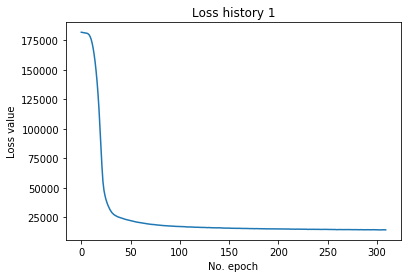

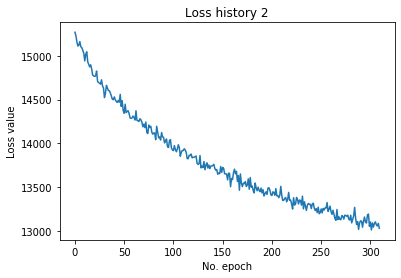

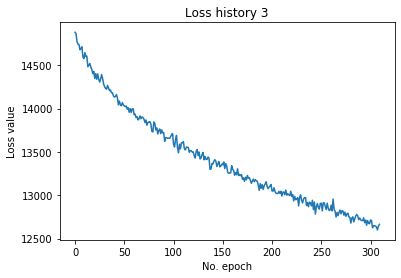

In [18]:
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import time

num_epochs = 310
batch_size = 30

folds = 3
k = KFold(n_splits=folds, shuffle=True)

loss_fold = []
fold_no = 1

for train, test in k.split(train_features, train_labels):
    start = time.time()
    
    history = model.fit(train_features[train], train_labels[train], batch_size=batch_size, epochs=num_epochs, verbose=0, callbacks=[tensorboard_callback])
    
    scores = model.evaluate(train_features[test], train_labels[test], verbose=0)
    
    end = time.time()
    
    batch_size += 6
    
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}')
    print(f'Time elapsed for fold: {round(end - start, 3)} seconds')
    print('--------------------------------------------')
    
    loss_fold.append(scores[0])
     
    # Print Loss for the fold
    plt.plot(history.history['loss'])
    plt.title(f'Loss history {fold_no}')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.show()
    
    fold_no += 1
    

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(loss_fold)}')
print('------------------------------------------------------------------------')

Save Results

In [19]:
preds = model.predict(test_features)

     # reformat it for export to Kaggle
test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
print(test_data['SalePrice'])
submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
submission.to_csv('submission_tf.csv', index=False)

0       118393.445312
1       151472.375000
2       182536.031250
3       195841.609375
4       187163.515625
            ...      
1454     85057.195312
1455     77293.367188
1456    165633.625000
1457    114175.750000
1458    204267.546875
Name: SalePrice, Length: 1459, dtype: float32


## Training

To get started we train a linear model with squared loss. This will obviously not lead to a competition winning submission but it provides a sanity check to see whether there's meaningful information in the data. It also amounts to a minimum baseline of how well we should expect any 'fancy' model to work.

Design a custom dataset and dataloader

In [20]:
from torch.utils.data import Dataset, DataLoader



class HousePriceDataset(Dataset):
    def __init__(self, train_features, train_labels):
        super().__init__()
        self.train_features = train_features
        self.train_labels = train_labels

    def __len__(self):
        return len(self.train_features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.train_features[idx], self.train_labels[idx])
        

In [21]:
import torch
from torch import nn

Revise the following neural network

In [22]:
## your code here

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        self.L1 = nn.Linear(input_dim, 160)
        self.L2 = nn.Linear(160, 80)
        self.L3 = nn.Linear(80, output_dim)

    def forward(self, xb):
        xb = torch.nn.functional.relu(self.L1(xb))
        xb = torch.nn.functional.relu(self.L2(xb))
        xb = self.L3(xb)
        return xb

In [23]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        print('yhat')
        print(yhat)
        print('y')
        print(y)
        return torch.sqrt(self.mse(yhat, y))

criterion = RMSELoss()


House prices, like shares, are relative. That is, we probably care more about the relative error $\frac{y - \hat{y}}{y}$ than about the absolute error. For instance, getting a house price wrong by USD 100,000 is terrible in Rural Ohio, where the value of the house is USD 125,000. On the other hand, if we err by this amount in Los Altos Hills, California, we can be proud of the accuracy of our model (the median house price there exceeds 4 million).

One way to address this problem is to measure the discrepancy in the logarithm of the price estimates. In fact, this is also the error that is being used to measure the quality in this competition. After all, a small value $\delta$ of $\log y - \log \hat{y}$ translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$. This leads to the following loss function:

$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$

In [24]:
## your code here

## Note: To further stabilize the value when the logarithm is taken, set the value of yhat less than 1 as 1.

class Log_RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

        
    def forward(self, yhat, y):
        # added large number to the yhat and y so they are always positive, log of a negative number doesn't exist
        # this doesnt affect the function of the log RMSE because it is just calulating a relative error which if both
        # have a large number added to them the relative error is still the same or at least functionally similar
        return torch.sqrt(self.mse(torch.log(yhat+1000000), torch.log(y+1000000))) 



The following training functions use the Adam optimization algorithm.  Compared to the mini-batch stochastic gradient descent, the Adam optimization algorithm is relatively less sensitive to learning rates. The details on various optimization algorithms are [here](http://d2l.ai/chapter_optimization/index.html).

In [25]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, batch_size):
    train_ls, test_ls = [], []
    train_dataset = HousePriceDataset(train_features, train_labels)
    train_iter = DataLoader(train_dataset, batch_size, shuffle=True)
    # The Adam optimization algorithm is used here.
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = Log_RMSELoss()

    for epoch in range(num_epochs):
        for X, y in train_iter:
            yhat = net(X.float())
            loss = criterion(yhat, y.float())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_ls.append(loss)
        if test_labels is not None:
            test_y_hat = net(torch.from_numpy(test_features).float())
            test_ls.append(criterion(test_y_hat, torch.from_numpy(test_labels).float()))
    return train_ls, test_ls

## k-Fold Cross-Validation

The k-fold cross-validation was introduced in the section where we discussed how to deal with [“Model Selection, Underfitting and Overfitting"](http://d2l.ai/chapter_multilayer-perceptrons/underfit-overfit.html). We will put this to good use to select the model design and to adjust the hyperparameters. We first need a function that returns the i-th fold of the data in a k-fold cros-validation procedure. It proceeds by slicing out the i-th segment as validation data and returning the rest as training data. Note - this is not the most efficient way of handling data and we would use something much smarter if the amount of data was considerably larger. But this would obscure the function of the code considerably and we thus omit it.

In [26]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = np.concatenate((X_train, X_part), axis=0)
            y_train = np.concatenate((y_train, y_part), axis=0)
    return X_train, y_train, X_valid, y_valid

The training and verification error averages are returned when we train $k$ times in the k-fold cross-validation.

In [27]:
## util function
from matplotlib import pyplot as plt
from IPython import display

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    """Plot x and log(y)."""

    def set_figsize(figsize=(3.5, 2.5)):
        """Set matplotlib figure size."""
        display.set_matplotlib_formats('svg')
        plt.rcParams['figure.figsize'] = figsize

    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()

In [28]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = MLP(all_features.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'log rmse',
                        range(1, num_epochs + 1), valid_ls,
                        ['train', 'valid'])
        print('fold %d, train mse: %f, valid mse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## Model Selection

We pick a rather un-tuned set of hyperparameters and leave it up to the reader to improve the model considerably. Finding a good choice can take quite some time, depending on how many things one wants to optimize over. Within reason the k-fold crossvalidation approach is resilient against multiple testing. However, if we were to try out an unreasonably large number of options it might fail since we might just get lucky on the validation split with a particular set of hyperparameters.

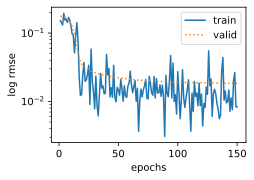

fold 0, train mse: 0.008306, valid mse: 0.018385
fold 1, train mse: 0.015096, valid mse: 0.024232
fold 2, train mse: 0.013824, valid mse: 0.022079
fold 3, train mse: 0.010667, valid mse: 0.017039
fold 4, train mse: 0.028210, valid mse: 0.032277
5-fold validation: avg train rmse: 0.015221, avg valid rmse: 0.022803


In [29]:
k, num_epochs, lr, batch_size = 5, 150, .0003, 12
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

You will notice that sometimes the number of training errors for a set of hyper-parameters can be very low, while the number of errors for the $K$-fold cross validation may be higher. This is most likely a consequence of overfitting. Therefore, when we reduce the amount of training errors, we need to check whether the amount of errors in the k-fold cross-validation have also been reduced accordingly.

##  Predict and Submit

Now that we know what a good choice of hyperparameters should be, we might as well use all the data to train on it (rather than just $1-1/k$ of the data that is used in the crossvalidation slices). The model that we obtain in this way can then be applied to the test set. Saving the estimates in a CSV file will simplify uploading the results to Kaggle.

In [30]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, batch_size):
    net = MLP(all_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, batch_size)
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'log rmse')
    print('train rmse %f' % train_ls[-1])
    # apply the network to the test set
    preds = net(torch.from_numpy(test_features).float()).data.numpy()
    # reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    print(test_data['SalePrice'])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

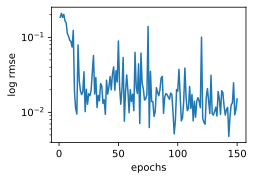

train rmse 0.015090
0       115514.335938
1       157078.015625
2       180403.359375
3       194302.703125
4       186180.562500
            ...      
1454     77213.351562
1455     68298.257812
1456    171392.343750
1457    106074.929688
1458    218596.328125
Name: SalePrice, Length: 1459, dtype: float32


In [31]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, batch_size)

A file, `submission.csv` will be generated by the code above (CSV is one of the file formats accepted by Kaggle).  Next, we can submit our predictions on Kaggle and compare them to the actual house price (label) on the testing data set, checking for errors. The steps are quite simple:

* Log in to the Kaggle website and visit the House Price Prediction Competition page.
* Click the “Submit Predictions” or “Late Submission” button on the right.
* Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.
* Click the “Make Submission” button at the bottom of the page to view your results.

## Hints

1. Can you improve your model by minimizing the log-price directly? What happens if you try to predict the log price rather than the price?
1. Is it always a good idea to replace missing values by their mean? Hint - can you construct a situation where the values are not missing at random?
1. Find a better representation to deal with missing values. Hint - What happens if you add an indicator variable?
1. Improve the score on Kaggle by tuning the hyperparameters through k-fold crossvalidation.
1. Improve the score by improving the model (layers, regularization, dropout).
1. What happens if we do not standardize the continuous numerical features like we have done in this section?